In [1]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Hyperparameters
image_size = 64
latent_dim = 100
hidden_dim = 256
batch_size = 128
epochs = 50
learning_rate = 1e-3
dataroot = 'data/'
ngpu = 1

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

## Encoder Model

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # input shape: 3 x 64 x 64, output shape: 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # input shape: 32 x 32 x 32, output shape: 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # input shape: 64 x 16 x 16, output shape: 128 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# input shape: 128 x 8 x 8, output shape: 256 x 4 x 4
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

## Decoder Model

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 256 * 4 * 4),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # input shape: 256 x 4 x 4, output shape: 128 x 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # input shape: 128 x 8 x 8, output shape: 64 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # input shape: 64 x 16 x 16, output shape: 32 x 32 x 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # input shape: 32 x 32 x 32, output shape: 3 x 64 x 64
            nn.Tanh()
        )
        
    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.deconv(x)
        return x

## VAE Model

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar

# Load Trained Model

In [9]:
from tqdm import tqdm

In [17]:
experiment_ids = ['vae_model', 'vae_exp002', 'vae_exp003', 'vae_exp004']
latent_dims = [100, 100, 200, 200]

In [26]:
def load_trained_model(expID, ngpu=1, device=device, latent_dim=100):
    torch.cuda.empty_cache()
    model = VAE(latent_dim).to(device)
    model.load_state_dict(torch.load(f'{expID}.pth'))
    model.eval()
    print('model is loaded!')
    return model

In [27]:
def generate_images(model, expID, num_images=25, latent_dim=100):
    for i in range(num_images):
        with torch.no_grad():
            noise = torch.randn(1, latent_dim).to(device)
            fake = model.decoder(noise).detach().cpu()
            fake_img = vutils.make_grid(fake, padding=2, normalize=True)
            transposed = np.transpose(vutils.make_grid(fake_img, padding=5, normalize=True).cpu(),(1,2,0))
            plt.imshow(transposed)
            plt.axis('off')
            plt.savefig(f'fake_images_vae/{expID}/images/image{i}.png')

0it [00:00, ?it/s]

model is loaded!


1it [03:31, 211.36s/it]

model is loaded!


2it [14:01, 420.71s/it]


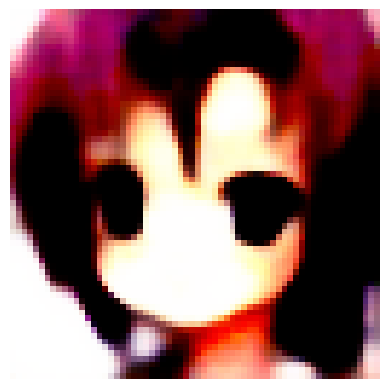

In [28]:
for expID, ld in tqdm(zip(['vae_exp003', 'vae_exp004'], [200, 200])):
    model = load_trained_model(expID, latent_dim=ld)
    generate_images(model, expID, num_images=250, latent_dim=ld)

In [21]:
with torch.no_grad():
    fixed_noise = torch.randn(1, latent_dim).to(device)
    img = loaded.decoder(fixed_noise).cpu()

(-0.5, 63.5, 63.5, -0.5)

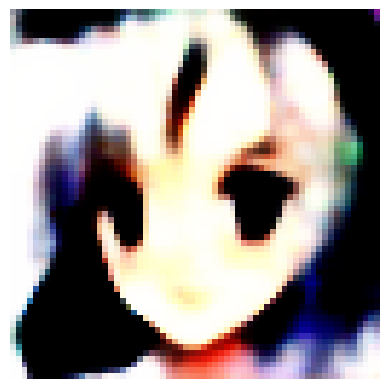

In [22]:
fake_img = vutils.make_grid(img, padding=2, normalize=True)
transposed = np.transpose(vutils.make_grid(fake_img, padding=5, normalize=True).cpu(),(1,2,0))
plt.imshow(transposed)
plt.axis('off')